<a href="https://colab.research.google.com/github/Josh0323/jcSementicSimilarityAnalysis/blob/main/weekNov18assignment_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from google.colab import files

import networkx as nx

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"



In [3]:
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [4]:
class SubjectData():
  def __init__(self, mod, filename):
    self.model = mod
    self.df = pd.read_excel(filename, index_col=0)
    self.movie_titles = self.df[~self.df['Movie title'].isna()]['Movie title'].values.tolist()
    self.event_desc = self.get_event_description()
    self.all_cos_sim_movies = self.get_all_cos_similarity()
    self.all_event_degrees = self.get_event_degrees()
  
  #returns a list that contains all event descriptions from 2 runs.
  #first index: each run
  #second index: each movie
  #third index: each event annotation
  def get_event_description(self):
    runs = []

    self.df = self.df.reset_index()

    #iterate each row of the dataframe to group the annotations by its corresponding event
    for index, row in self.df.iterrows():

      #if Scanning run value isn't NaN, new run has been encounterd. Thus, increment the index.
      if not pd.isna(row['Scanning run']):
        new_run = []
        runs.append(new_run)

      if not pd.isna(row['Movie title']):
        new_movie = []
        runs[-1].append(new_movie)

      cur_seg = row['Segment number']

      #check if the current annotation belongs to the same event as the previous one
      #if the segment number is not NaN, it is new event
      if not pd.isna(cur_seg):
        new_event = row['Description']
        runs[-1][-1].append(new_event)
      #if the segment number is NaN, it belongs to the current event
      else:
        runs[-1][-1][-1] += " " + row['Description']
      
    return runs

  def calculate_cos_similarity(self, event):
    message_embeddings = self.model(event)
    mgs_emb = message_embeddings.numpy()

    #find cosine similarity 
    dist_out = 1-pairwise_distances(mgs_emb, metric="cosine")
    return dist_out

  def get_all_cos_similarity(self):
    # contains each cosine similarity matrix of all movies
    cos_sim_movies = []

    # plot all the cosine similarities of the movies
    for run in range(len(self.event_desc)):
      for movies in range(len(self.event_desc[run])):
        event = self.event_desc[run][movies]
        dist = self.calculate_cos_similarity(event)
        cos_sim_movies.append(dist)
    return cos_sim_movies

  def plot_similarity(self, dist, movie_title):
    mask = np.triu(np.ones_like(dist, dtype=int))
    
    g = sns.heatmap(
          dist, 
          mask=mask,
          vmin=0,
          vmax=1,
          cmap="YlGnBu")
    g.set_xlabel('Events')
    g.set_ylabel('Events')
    title = movie_title + " Event Cosine Similarity"
    g.set_title(title)
    plt.savefig(title + '.png')
    plt.clf()

  # calculates the degree of each event in the movies of the subject
  # returns a 2d array where the inner list contains the event degrees of an event
  def get_event_degrees(self):
    # output array
    movies = []

    # iterate through each movie
    for movie in self.all_cos_sim_movies:
      events_in_movie = []
      # iterate to find the degree of each event
      # we add ith row and column values to find the degree of ith event
      for i in range(len(movie)):
        degree = 0

        # sum the ith row values of the ith event
        if i != 0:
          degree += sum(movie[0][:i])
        # sum the ith column values of the ith event
        for j in range(len(movie)):
          degree += movie[j][i]

        # append the node degree into movie array
        events_in_movie.append(degree)

      # append the movie into the output array        
      movies.append(events_in_movie)
    return movies

  def get_event_histogram(self):
    for i in range(len(self.all_event_degrees)):
      plt.hist(self.all_event_degrees[i])
      plt.xlabel("Node degree")
      plt.ylabel("Number of each degree")
      plt.title(self.movie_titles[i] + "'s Semantic Narrative Network Historgram")
      plt.show()

  # create a graph of semantic network
  def get_semantic_network(self, e_thres=0.6, scale = 4):
    for mov_idx, movie in enumerate(self.all_event_degrees):
      if mov_idx == 0 or mov_idx == 6: continue
      G = nx.Graph()

      for e_idx, e in enumerate(self.all_event_degrees[mov_idx]):
        G.add_node(e_idx, degree=e)

      cur_cos_sim = self.all_cos_sim_movies[mov_idx]

      for row in range(len(cur_cos_sim)):
        for col in range(row + 1, len(cur_cos_sim)):
          w = cur_cos_sim[row][col]
          if w >= e_thres:
            G.add_edge(row, col, weight = w)

      l = nx.get_node_attributes(G,'degree').values()
      lm = max(l)
      n_size = [i / lm * 50 for i in l ]
      
      weights = nx.get_edge_attributes(G,'weight').values()
      vm = max(weights)
      vmin= min(weights)

      options = {
        "with_labels": False,
        "node_size": n_size, 
        "edge_color": weights,
        "width": 3,
        "edge_cmap": plt.cm.binary,
        "edge_vmin": vmin, 
        "edge_vmax": vm,  
      }

      pos=nx.spring_layout(G,scale=scale)
      nx.draw_networkx(G, pos, **options)
      plt.title(self.movie_titles[mov_idx])
      plt.show()

In [5]:
s1 = SubjectData(model, 'drive/MyDrive/Colab Notebooks/data/FilmFestival_movie_annotation_JL.xlsx')

In [6]:
s2 = SubjectData(model, 'drive/MyDrive/Colab Notebooks/data/FilmFestival_movie_annotation_RC.xlsx')

In [7]:
s3 = SubjectData(model, 'drive/MyDrive/Colab Notebooks/data/FilmFestival_movie_annotation_KM.xlsx')

In [8]:
for run in range(len(s1.event_desc)):
  for movie in range(len(s1.event_desc[run])):
    print("s1's run " + str(run) + ", movie " + str(movie) + ", events: "+ str(len(s1.event_desc[run][movie])))

s1's run 0, movie 0, events: 2
s1's run 0, movie 1, events: 24
s1's run 0, movie 2, events: 15
s1's run 0, movie 3, events: 26
s1's run 0, movie 4, events: 13
s1's run 0, movie 5, events: 26
s1's run 1, movie 0, events: 2
s1's run 1, movie 1, events: 28
s1's run 1, movie 2, events: 17
s1's run 1, movie 3, events: 11
s1's run 1, movie 4, events: 16
s1's run 1, movie 5, events: 36


In [9]:
for run in range(len(s2.event_desc)):
  for movie in range(len(s2.event_desc[run])):
    print("s2's run " + str(run) + ", movie " + str(movie) + ", events: "+ str(len(s2.event_desc[run][movie])))

s2's run 0, movie 0, events: 2
s2's run 0, movie 1, events: 24
s2's run 0, movie 2, events: 15
s2's run 0, movie 3, events: 26
s2's run 0, movie 4, events: 13
s2's run 0, movie 5, events: 26
s2's run 1, movie 0, events: 2
s2's run 1, movie 1, events: 28
s2's run 1, movie 2, events: 17
s2's run 1, movie 3, events: 11
s2's run 1, movie 4, events: 16
s2's run 1, movie 5, events: 36


In [10]:
for run in range(len(s3.event_desc)):
  for movie in range(len(s3.event_desc[run])):
    print("s3's run " + str(run) + ", movie " + str(movie) + ", events: "+ str(len(s3.event_desc[run][movie])))

s3's run 0, movie 0, events: 2
s3's run 0, movie 1, events: 24
s3's run 0, movie 2, events: 15
s3's run 0, movie 3, events: 26
s3's run 0, movie 4, events: 13
s3's run 0, movie 5, events: 26
s3's run 1, movie 0, events: 2
s3's run 1, movie 1, events: 28
s3's run 1, movie 2, events: 17
s3's run 1, movie 3, events: 11
s3's run 1, movie 4, events: 16
s3's run 1, movie 5, events: 36


In [11]:
df = pd.read_excel('drive/MyDrive/Colab Notebooks/data/FilmFestival_movie_annotation_JL.xlsx', index_col=0)
movie_titles = df[~df['Movie title'].isna()]['Movie title'].values.tolist()

def plot_similarity(dist, movie_title):
  mask = np.triu(np.ones_like(dist, dtype=int))
  
  g = sns.heatmap(
        dist, 
        mask=mask,
        vmin=0,
        vmax=1,
        cmap="YlGnBu")
  g.set_xlabel('Events')
  g.set_ylabel('Events')
  title = movie_title + " Event Cosine Similarity"
  g.set_title(title)
  plt.savefig(title + '.png')
  #files.download(title + '.png')
  plt.show()
  plt.clf()

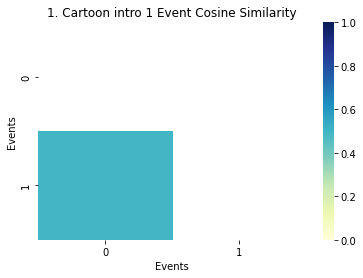

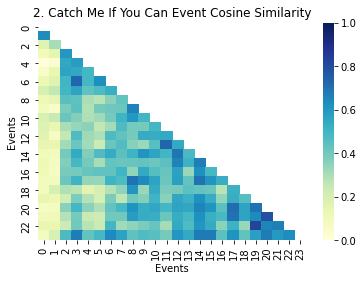

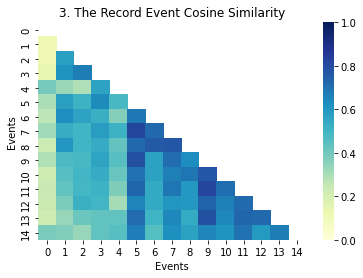

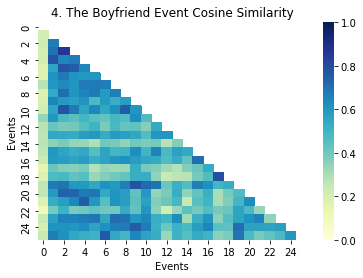

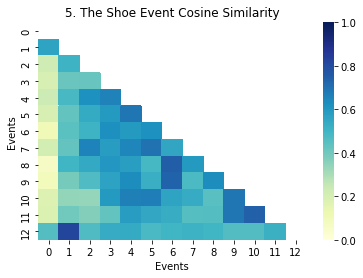

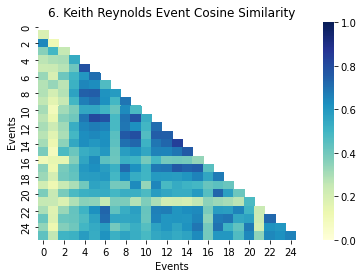

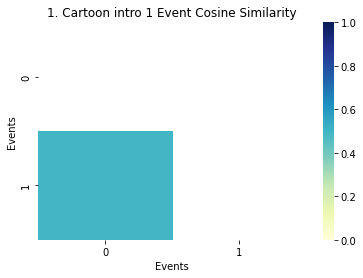

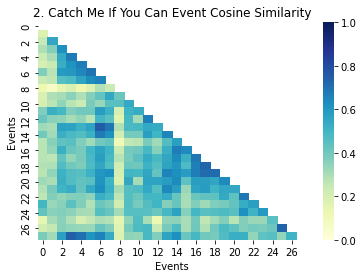

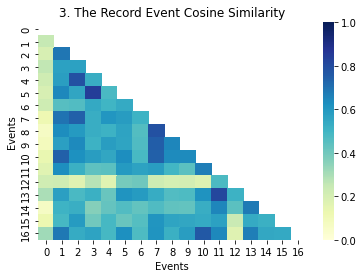

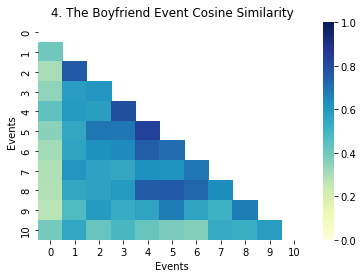

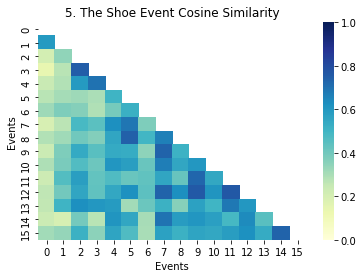

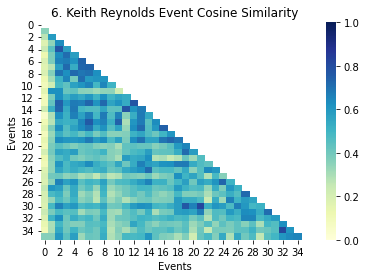

<Figure size 432x288 with 0 Axes>

In [12]:
avg_cos_mat = []
for run in range(len(s1.event_desc)):
  for movie in range(len(s1.event_desc[run])):
    s1_sen = model(s1.event_desc[run][movie]).numpy()
    s2_sen = model(s2.event_desc[run][movie]).numpy()
    s3_sen = model(s3.event_desc[run][movie]).numpy()

    avg_sen = (s1_sen + s2_sen + s3_sen) / 3
    dist_out = 1-pairwise_distances(avg_sen, metric="cosine")
    plot_similarity(dist_out, movie_titles[movie])
    avg_cos_mat.append(dist_out)

In [13]:
def get_event_degrees():
    # output array
    movies = []

    # iterate through each movie
    for movie in avg_cos_mat:
      events_in_movie = []
      # iterate to find the degree of each event
      # we add ith row and column values to find the degree of ith event
      for i in range(len(movie)):
        degree = 0

        # sum the ith row values of the ith event
        if i != 0:
          degree += sum(movie[0][:i])
        # sum the ith column values of the ith event
        for j in range(len(movie)):
          degree += movie[j][i]

        # append the node degree into movie array
        events_in_movie.append(degree)

      # append the movie into the output array        
      movies.append(events_in_movie)
    return movies

def get_event_histogram(event_degrees, movie_titles):
  for i in range(len(event_degrees)):
    plt.hist(event_degrees[i])
    plt.xlabel("Node degree")
    plt.ylabel("Number of each degree")
    plt.title(movie_titles[i] + "'s Semantic Narrative Network Historgram")
    plt.show()

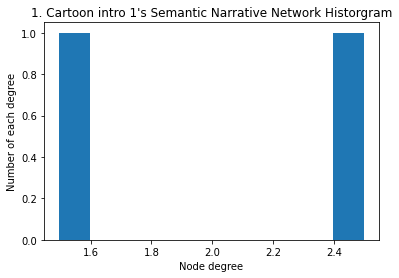

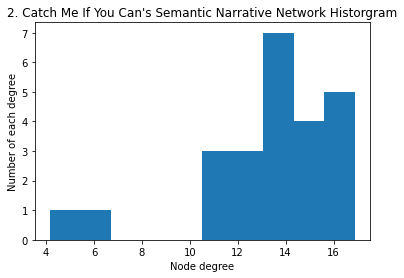

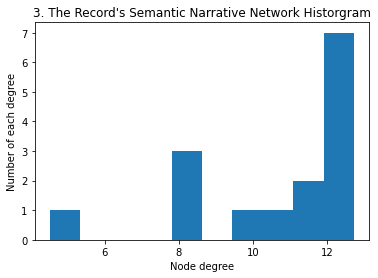

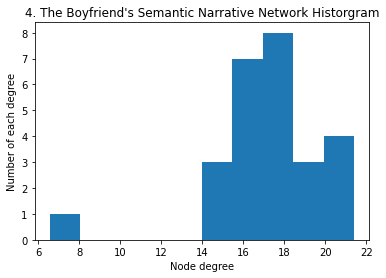

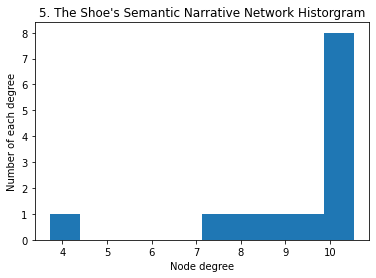

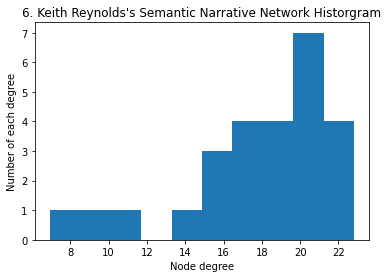

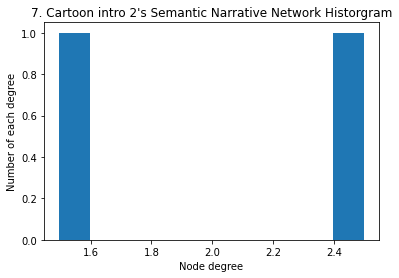

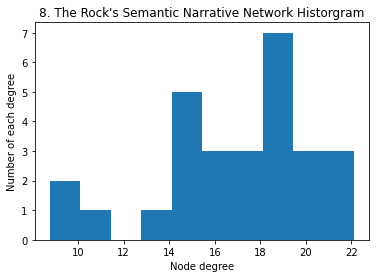

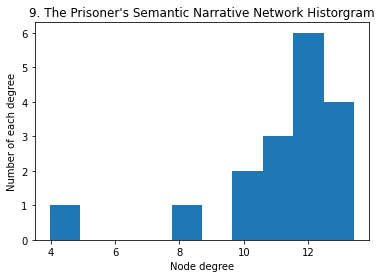

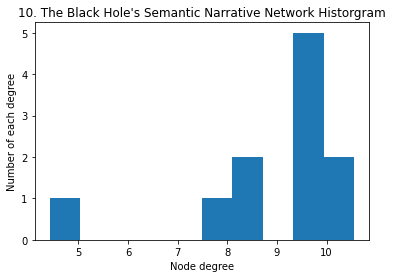

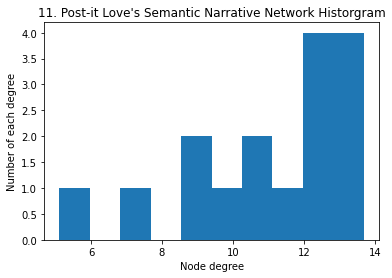

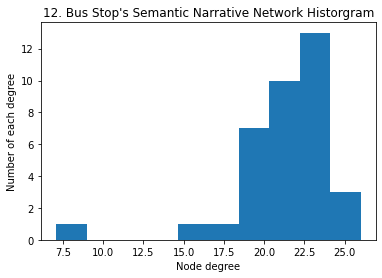

In [14]:
e_deg = get_event_degrees()
get_event_histogram(e_deg, movie_titles)

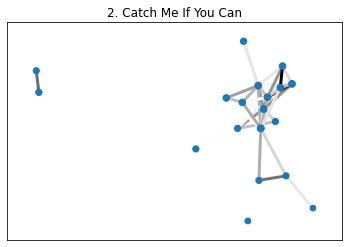

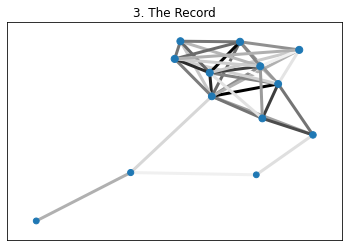

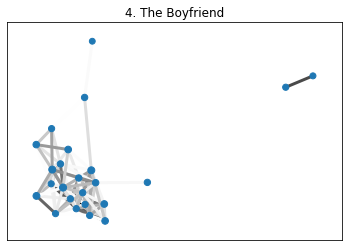

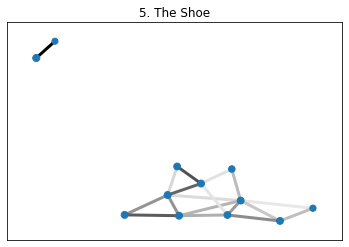

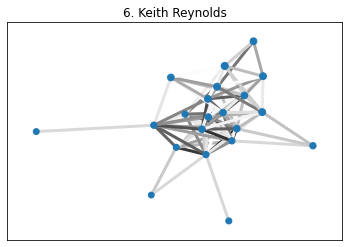

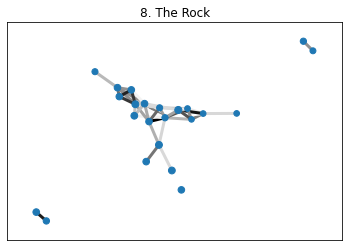

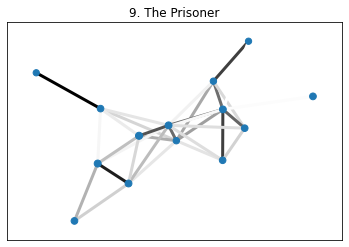

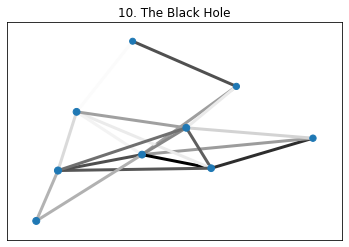

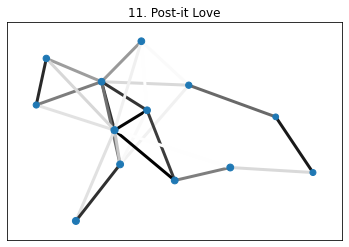

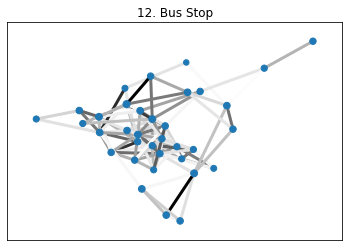

In [15]:
for mov_idx, movie in enumerate(e_deg):
  if mov_idx == 0 or mov_idx == 6: continue
  G = nx.Graph()

  for e_idx, e in enumerate(e_deg[mov_idx]):
    G.add_node(e_idx, degree=e)

  cur_cos_sim = avg_cos_mat[mov_idx]

  for row in range(len(cur_cos_sim)):
    for col in range(row + 1, len(cur_cos_sim)):
      w = cur_cos_sim[row][col]
      if w >= 0.6 and row != 0:
        G.add_edge(row, col, weight = w)
    if row == 0 or G.degree(row) == 0:
      G.remove_node(row)
  

  l = nx.get_node_attributes(G,'degree').values()
  lm = max(l)
  n_size = [i / lm * 50 for i in l ]
  
  weights = nx.get_edge_attributes(G,'weight').values()
  vm = max(weights)
  vmin= min(weights)

  options = {
    "with_labels": False,
    "node_size": n_size, 
    "edge_color": weights,
    "width": 3,
    "edge_cmap": plt.cm.binary,
    "edge_vmin": vmin,   
    "edge_vmax": vm,  
}

  pos=nx.spring_layout(G,scale=10)
  nx.draw_networkx(G, pos, **options)
  plt.title(movie_titles[mov_idx])
  plt.show()

In [16]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [17]:
colors = [plt.cm.Oranges, plt.cm.Blues, plt.cm.Greens, plt.cm.Reds, plt.cm.Purples]

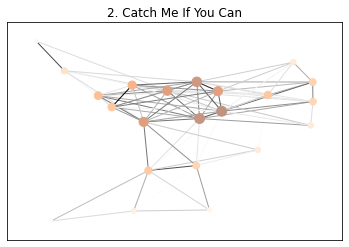

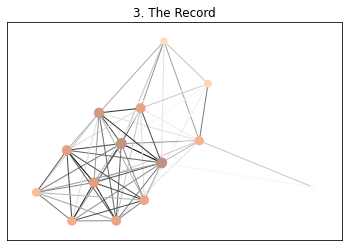

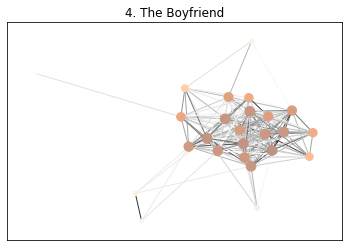

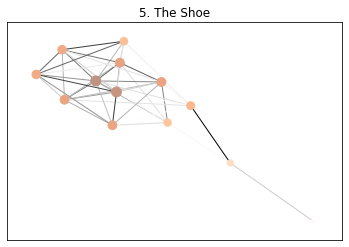

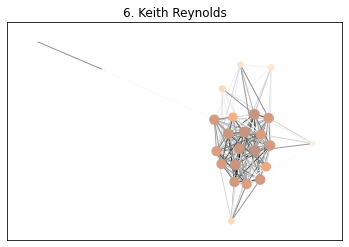

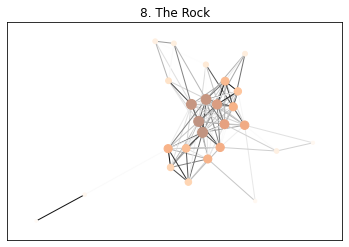

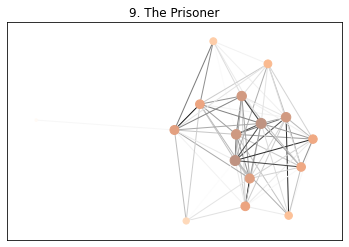

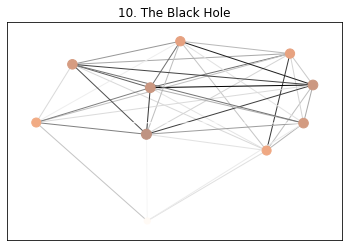

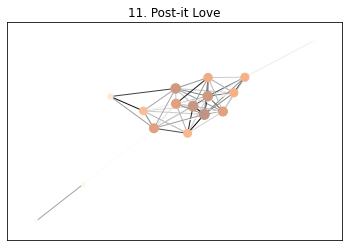

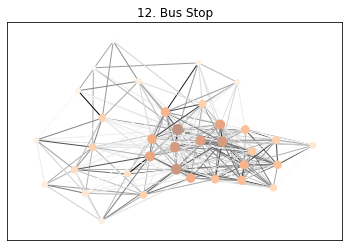

In [18]:
for mov_idx, movie in enumerate(e_deg):
  if mov_idx == 0 or mov_idx == 6: continue

  cur_cos_sim = np.array(avg_cos_mat[mov_idx])
  cur_cos_sim[(cur_cos_sim <= 0.5) | (cur_cos_sim == 1)] = 0

  G = nx.from_numpy_array(cur_cos_sim, create_using=nx.Graph())

  #G.remove_nodes_from(list(nx.isolates(G)))  
  G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

  nodes,node_size = zip(*dict(G.degree(weight='weight')).items())
  node_size = [v / max(node_size) * 100 for v in node_size]
  edges,edge_weights = zip(*nx.get_edge_attributes(G,'weight').items())

  options = {
    "with_labels": False,
    "nodelist" : nodes,
    "node_size": node_size, 
    "node_color" : node_size,
    "cmap" : cmap_map(lambda x: x/2 + 0.5, plt.cm.Oranges),
    "edgelist" : edges,
    "edge_color": edge_weights,
    "edge_cmap": plt.cm.binary, 
  }
  pos=nx.spring_layout(G)
  nx.draw_networkx(G, pos, **options)
  plt.title(movie_titles[mov_idx])
  plt.show()

  